<div class="alert alert-block alert-info">
<b>Note:</b> The goal of this notebook is to show you how to work with the Bayesian Statistics Toolbox (BST) when performing an analysis that involves comparing the effect of multiple nominal predictors on a metric outcome (think two-way and mixed-model ANOVAs) that may be normally or non-normally distributed (the "robust" version). These models utilize multi-level (hierarchical) modeling, one of the great strengths of Bayesian modeling. This is an adaptation of Jordi Warmenhoven's PyMC3 port of Chapter 20 of John Kruschke's textbook "Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan" (https://github.com/JWarmenhoven/DBDA-python). Please note that the code has been updated to make use of PyMC4 and that this does not (yet) include all of the examples from the original. </div>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import aesara.tensor as at

# Import BST
import src.bayesian_stats as bst

from IPython.display import Image

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [3]:
df = pd.read_csv('data/HtWtData110.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    110 non-null    int64  
 1   height  110 non-null    float64
 2   weight  110 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [45]:
X = df[["weight", "height"]]
y = df["male"]

zX, mu_X, sigma_X = bst.standardize(X)

### Kruschke-style graphical model 

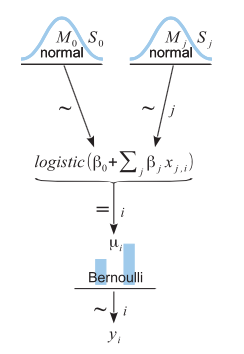

In [5]:
Image('images/fig21_2.png')

In [54]:
def bayesian_logistic_regression(X, y, n_draws=1000):
    
    zX, mu_X, sigma_X = bst.standardize(X)
    
    with pm.Model(coords={"predictors": X.columns.values}) as model:
        # Set  priors
        zbeta0 = pm.Normal("zbeta0", mu=0, sigma=2)
        zbetaj = pm.Normal("zbetaj", mu=0, sigma=2, dims="predictors")
        
        p = pm.invlogit(zbeta0 + pm.math.dot(zX, zbetaj))
        
        # Define likelihood function
        likelihood = pm.Bernoulli("likelihood", p, observed=y)
        
        # Transform parameters to original scale
        beta0 = pm.Deterministic("beta0", (zbeta0 - at.math.sum(zbetaj * mu_X / sigma_X)))
        betaj = pm.Deterministic("betaj", zbetaj / sigma_X, dims="predictors")                         
        
        # Sample from the posterior
        idata = pm.sample(draws=n_draws)
        
        return model, idata

In [55]:
# Fit your Bayesian model using BST
model, idata = bayesian_logistic_regression(X, y, n_draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbetaj]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 17 seconds.


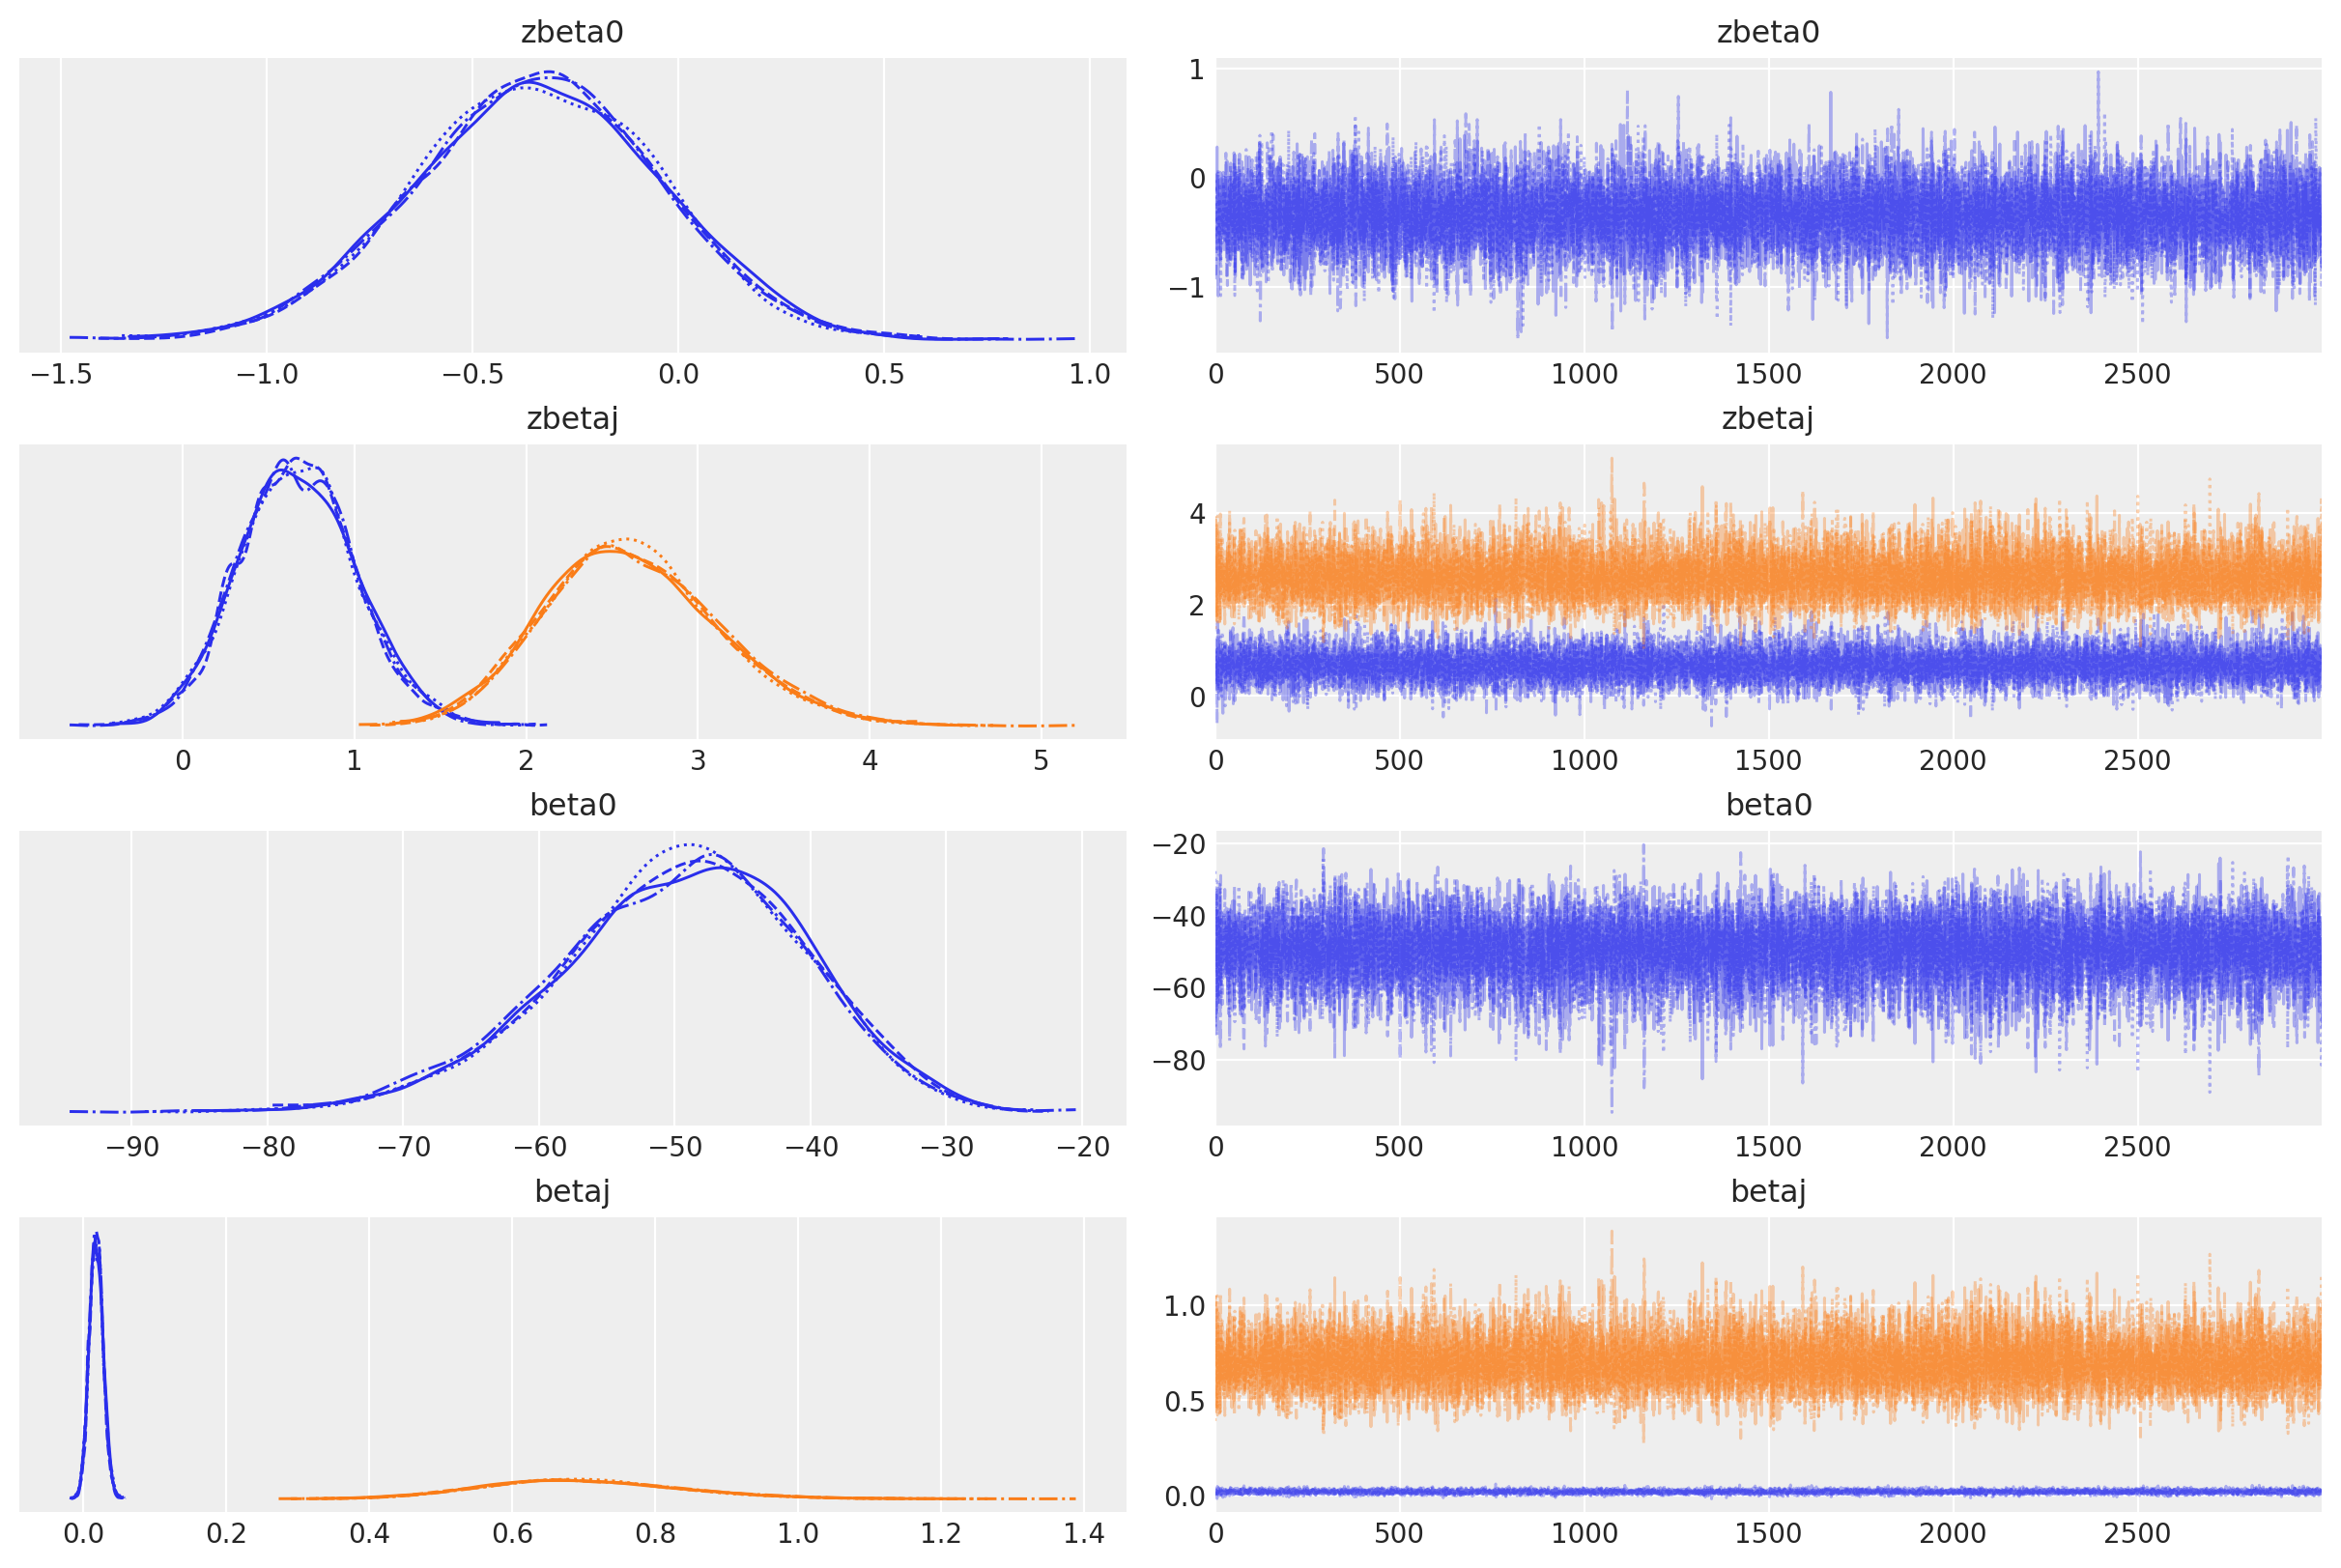

In [56]:
az.plot_trace(idata);

In [57]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

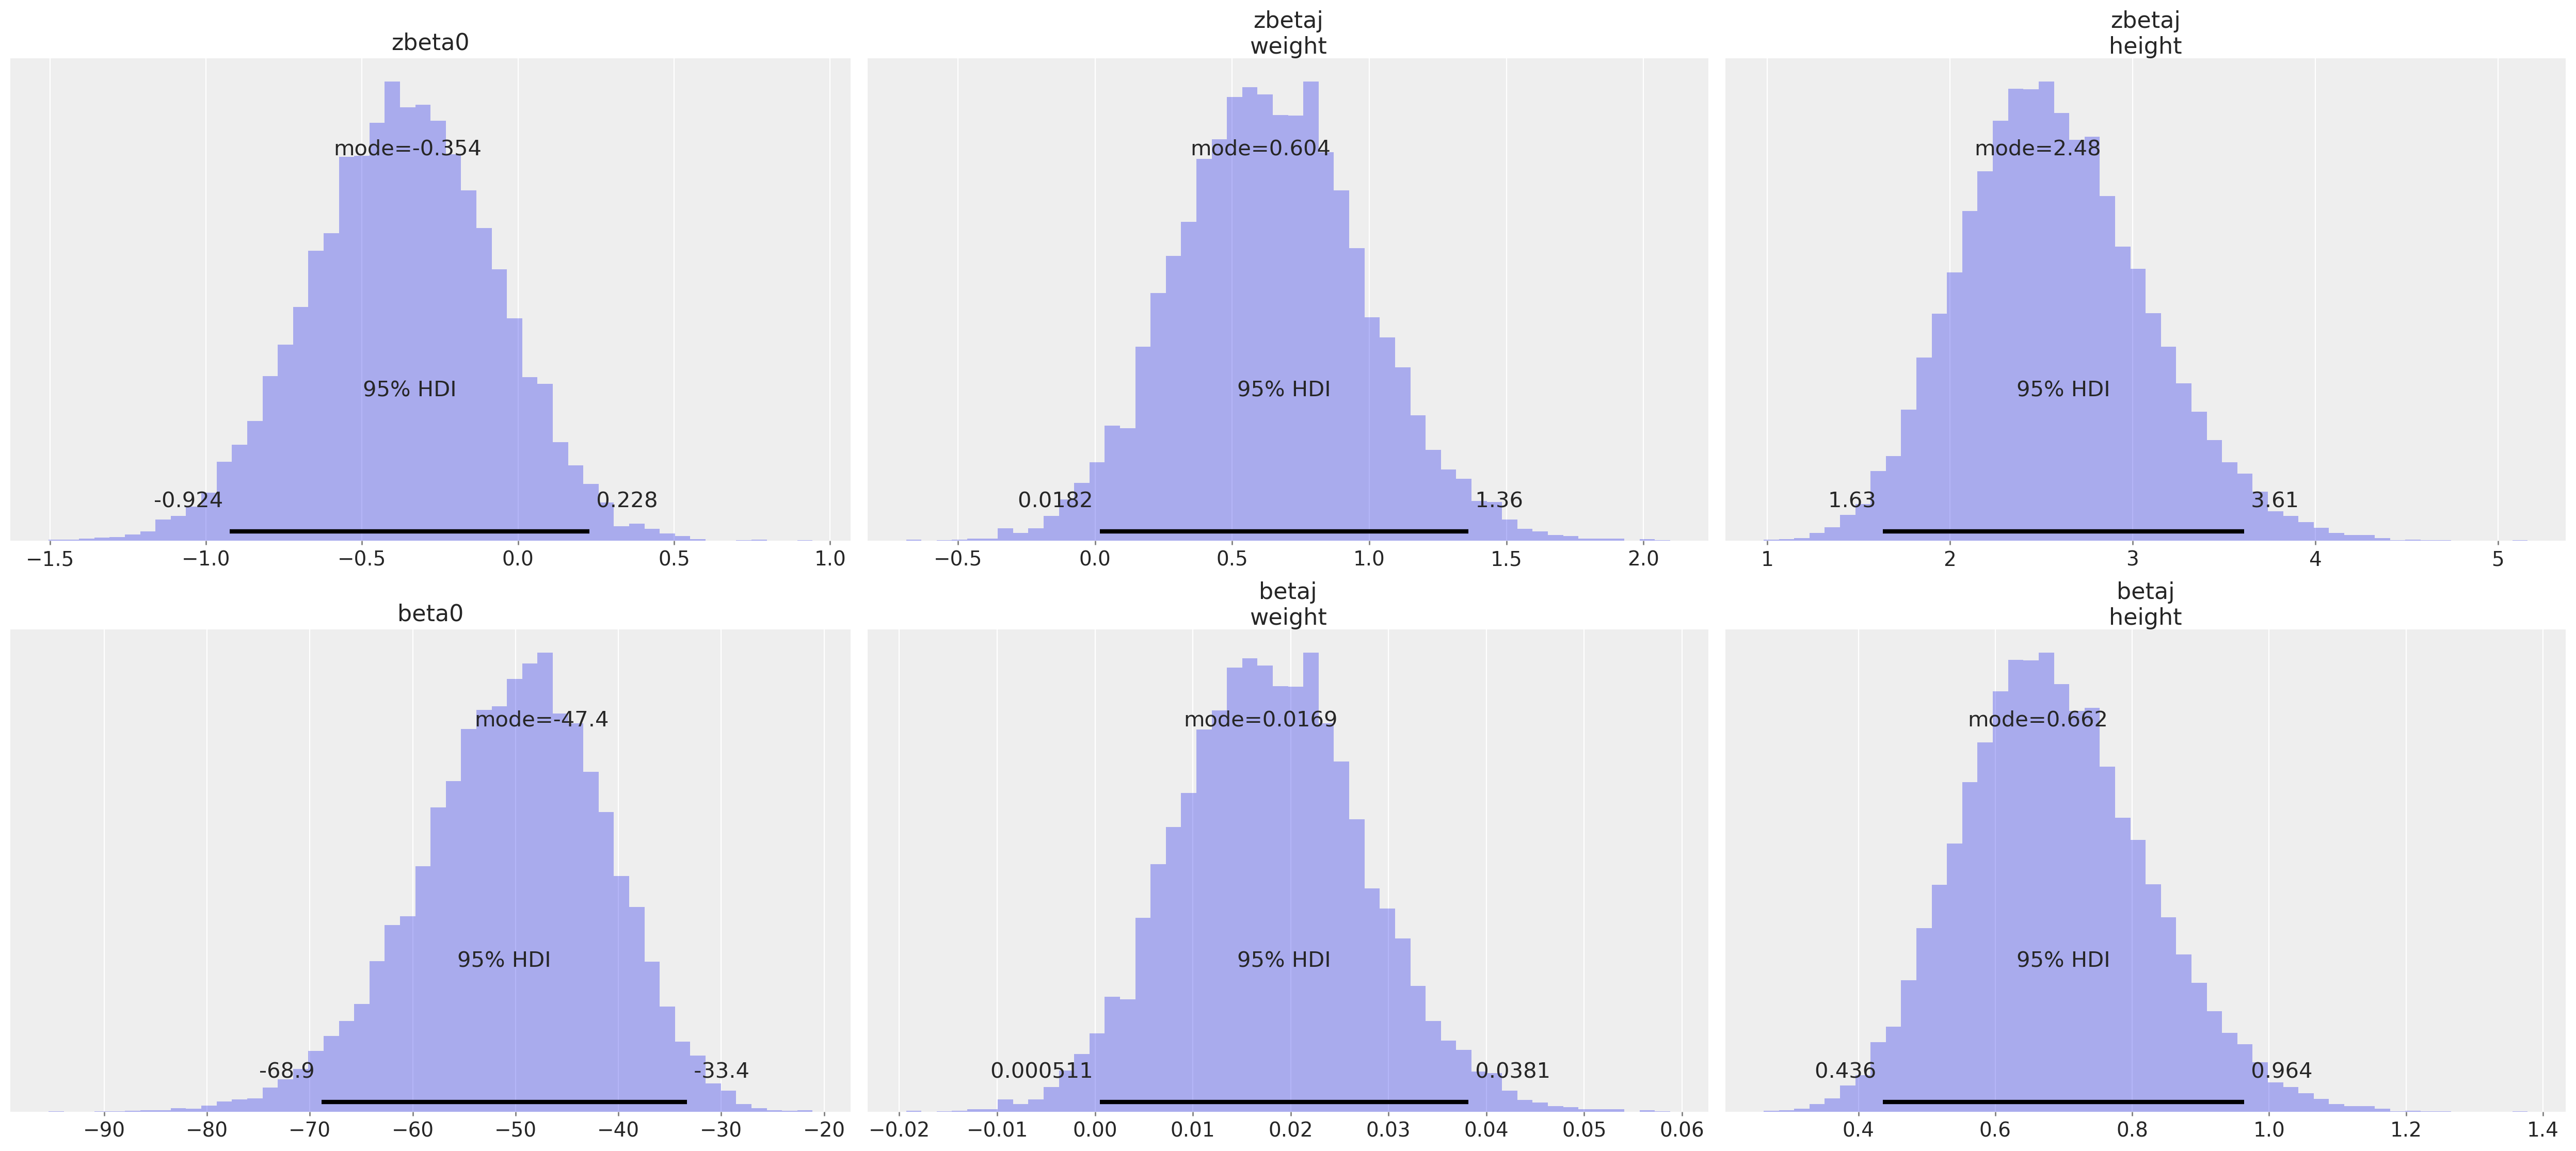

In [58]:
az.plot_posterior(idata, kind="hist", bins=50, point_estimate="mode", round_to=3, coords={"predictors": ["weight", "height"]});